# Final Project: Load balancing
## Part 2 : Tabular Model-Free control

#### Temporal-Difference Learning

Author : Jed MOUTAHIR

In [38]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 0
        self.Q2 = 0
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return -(self.state[0] + self.state[1])
    
    def step(self, action):
        # Take action (0 or 1) and return reward.
        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        elif(event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        elif(self.Q1 < self.Q1_max and self.Q2 < self.Q2_max and event < self.mu1 + self.mu2 + self.lambdA):
            # Choose queue
            if(self.Q1 == self.Q1_max):
                self.Q2 += 1
            elif(self.Q2 == self.Q2_max):
                self.Q1 += 1
            elif(action == 0):
                self.Q1 += 1
            elif(action == 1):
                self.Q2 += 1
        else:
            if((self.Q1 > self.Q1_max or self.Q2 > self.Q2_max) and (event < self.mu1 + self.mu2 + self.lambdA)):
                print("Error: impossible state : ")
                print("Q1 = ", self.Q1)
                print("Q2 = ", self.Q2)
                print("event = ", event)
                print("action = ", action)
                print("lambdA = ", self.lambdA)
                print("mu1 = ", self.mu1)
                print("mu2 = ", self.mu2)

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [40]:
def optimalControlMDP(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N, delta):
    # function that computes the optimal control of the MDP
    
    Q1_max, Q2_max = Q1_max + 1, Q2_max + 1

    pi = np.zeros((Q1_max, Q2_max)) 

    V = np.zeros((Q1_max, Q2_max))

    previous_V = np.zeros((Q1_max, Q2_max))

    # Compute optimal value function
    iteration = 0
    while(np.max(np.abs(V - previous_V)) > delta or iteration < N):
        iteration += 1
        for i in np.arange(Q1_max):
            for j in np.arange(Q2_max):
                if(i == Q1_max - 1 and j == Q2_max - 1):
                    V[i, j] = - i - j + gamma * (
                        + mu2 * previous_V[i, j - 1]
                        + mu1 * previous_V[i - 1, j]
                        + (1 - mu1 - mu2 - lambdA) * previous_V[i, j]
                    )

                elif(i == 0):
                    if(j == Q2_max - 1):
                        V[i, j] = - j + gamma * (
                            lambdA * previous_V[i + 1, j] +
                            mu2 * previous_V[i, j - 1] +
                            (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )
                    else :
                        max_value = np.max([previous_V[i, j + 1], previous_V[i + 1, j]])
                        V[i, j] = - j + gamma * (
                            lambdA * max_value +
                            mu2 * previous_V[i, j - 1] +
                            (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                            )

                elif(j == 0):
                    if(i == Q1_max - 1):
                        V[i, j] = - i + gamma * (
                            lambdA * previous_V[i, j + 1] +
                            mu1 * previous_V[i - 1, j] +
                            (1 - lambdA - mu2 - mu1) * previous_V[i, j]
                        )
                    else:
                        max_value = np.max([previous_V[i, j + 1], previous_V[i + 1, j]])
                        V[i, j] = - i + gamma * (
                            lambdA * max_value +
                            mu1 * previous_V[i - 1, j] +
                            (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                            )

                elif(i == Q1_max - 1):
                    V[i, j] = - i - j + gamma * (
                        lambdA * (
                            previous_V[i, j + 1]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                elif(j == Q2_max - 1):
                    V[i, j] = - i - j + gamma * (
                        lambdA * (
                            previous_V[i + 1, j]
                            ) +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                    )
                else:
                    max_value = np.max([previous_V[i, j + 1], previous_V[i + 1, j]])
                    V[i, j] = - i - j + gamma * (
                        lambdA * max_value +
                        mu1 * previous_V[i - 1, j] +
                        mu2 * previous_V[i, j - 1] +
                        (1 - lambdA - mu1 - mu2) * previous_V[i, j]
                        )
        previous_V = V
    
    # Compute optimal policy
    for i in np.arange(Q1_max):
        for j in np.arange(Q2_max):
            if(i == Q1_max - 1):
                pi[i, j] = 0
            elif(j == Q2_max - 1):
                pi[i, j] = 1
            else:
                if(V[i + 1, j] >= V[i, j + 1]):
                    pi[i, j] = 0
                else:
                    pi[i, j] = 1

    print("Converged in ", iteration, " iterations.")
    return pi, V[:Q1_max, :Q2_max]

In [103]:
def TD_0(pi, gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N, alpha=0.1, eps=1e-5):
    """ Function that implements the TD(0) algorithm. """

    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)

    # Initialize value function with zeros
    V = np.zeros((env.Q1_max+1, env.Q2_max+1))

    # Visit counter
    visit_counter = np.zeros((env.Q1_max+1, env.Q2_max+1))

    policy = pi

    for k in np.arange(N):
                
        # Initial state
        # Random initial state
        state = (np.random.randint(0, env.Q1_max+1), np.random.randint(0, env.Q2_max+1))

        # Choose action
        if(policy[state[0], state[1]] == 0):
            action = 0
        else:
            action = 1

        visit_counter[state[0], state[1]] += 1
        env.state = state
        env.Q1 = state[0]
        env.Q2 = state[1]

        # Next state and reward
        reward, next_state = env.step(action)

        visit_counter[next_state[0], next_state[1]] += 1

        # Update value function
        #alpha_n = alpha / np.sqrt(visit_counter[state[0], state[1]] + 1)
        alpha_n = alpha / np.log(visit_counter[state[0], state[1]] + 1)
        #alpha_n = 1 / np.log(np.log(visit_counter[state[0], state[1]] + 1) + 1)
        #alpha_n = alpha
        V[state[0], state[1]] = (1 - alpha_n) * V[state[0], state[1]] + alpha_n * (reward + gamma * V[next_state[0], next_state[1]])

        #print(V[state[0], state[1]])

    #print("Value function: ", V[:, :])

    return V, visit_counter

In [104]:
# Parameters
lambdA = 0.3
mu1 = 0.2
mu2 = 0.4
gamma = 0.99
Q1_max = 20
Q2_max = 20

In [105]:
# Compute optimal policy using MDP
pi, V_opt = optimalControlMDP(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, 100, 1e-5)

# Compute optimal policy using TD(0)
N = 1000000
V, visit_counter = TD_0(pi, gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N)

Converged in  100  iterations.


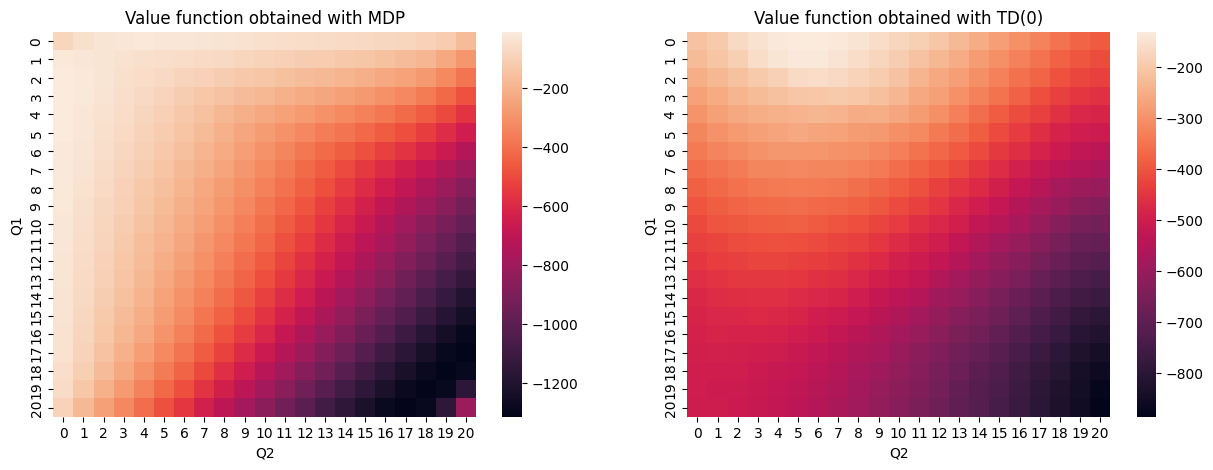

In [106]:
# Plot the value functions using sns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(V_opt, ax=ax[0], fmt=".2f")
ax[0].set_title("Value function obtained with MDP")
ax[0].set_xlabel("Q2")
ax[0].set_ylabel("Q1")
sns.heatmap(V, ax=ax[1], fmt=".2f")
ax[1].set_title("Value function obtained with TD(0)")
ax[1].set_xlabel("Q2")
ax[1].set_ylabel("Q1")
plt.savefig("TD0_value_function_ln.png")
plt.show()

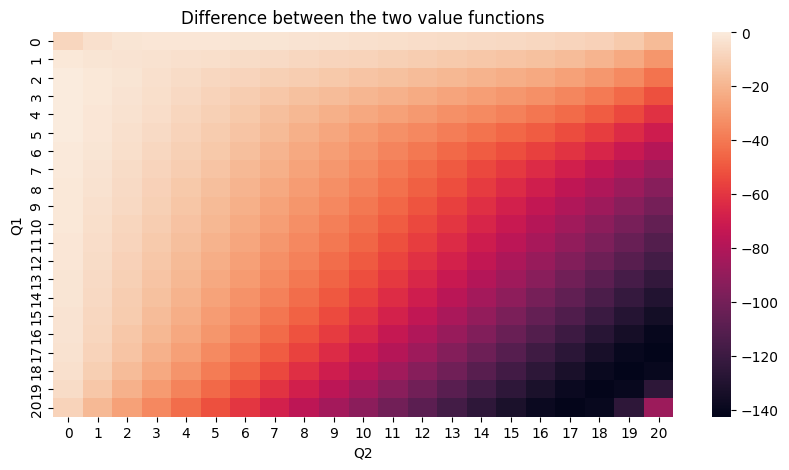

In [85]:
# Normalize V and V_opt
V_norm = V / np.max(V)
V_opt_norm = V_opt / np.max(V_opt)

# Plot the difference between the two value functions
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(V_norm - V_opt_norm, ax=ax, fmt=".2f")
ax.set_title("Difference between the two value functions")
ax.set_xlabel("Q2")
ax.set_ylabel("Q1")
plt.show()

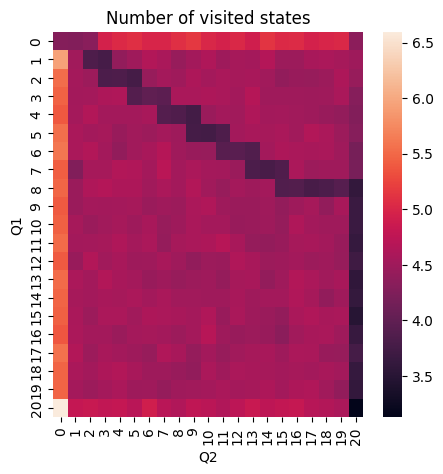

In [86]:
# Plot the number of visited states
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(visit_counter[:, :]/1000, ax=ax, annot=False)
ax.set_title("Number of visited states")
ax.set_xlabel("Q2")
ax.set_ylabel("Q1")
plt.show()